### Script to plot maps using TC-tracked mask

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker, cm, colors
import matplotlib.pyplot as plt
import sys
import cartopy
import subprocess
from mask_tc_track import mask_tc_track
from azim_wind_latlon import azim_wind_latlon
from thermo_functions import relh#density_moist, theta_equiv, theta_virtual, 

#### Main Settings

In [2]:
istrat=-1 #2

# #### Time selection

# nd = 3 # ndays
nt = 1#nd*24

# This has been tested for corresponding time steps:
#   t0=37,1 are the first divergent time steps in CTL,NCRF
#   t0=25,1 are the first divergent time steps in NCRF,CRFON
t0=96
t1 = t0+nt

# Pressure level to plot
pres_plot = 500

# #### Directories

# storm='haiyan'
storm='maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'

memb='memb_09'
test='ctl'

datdir2 = 'post/d02/'
# datdir2 = 'post/d02/v2/'
datdir = main+storm+'/'+memb+'/'+test+'/'+datdir2
# datdir+='v2/'

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (km) limit to keep unmasked

track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
# track_file = datdir+'../../../track_'+var_track+'_'+ptrack+'hPa.nc'

In [3]:
# TC Track
ncfile = Dataset(track_file)
clon = ncfile.variables['clon'][:] # deg
clat = ncfile.variables['clat'][:] # deg
ncfile.close()

In [4]:
##### Get dimensions
process = subprocess.Popen(['ls '+datdir+'../../wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
lat1d = lat[:,0]
lon1d = lon[0,:]
nx1 = lat1d.size
nx2 = lon1d.size
varfil_main.close()

varfil_main = Dataset(datdir+'T.nc')
pres = varfil_main.variables['pres'][:] # hPa
nz = pres.size
varfil_main.close()

ikread = np.where(pres == pres_plot)[0][0]

In [5]:
def var_read_3d(datdir,varname,t0,t1,ik):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,ik,:,:]
    var = var[:,np.newaxis,:,:]
    varfil_main.close()
    return var
def var_read_2d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var

#### Read variables

In [6]:
# Read winds
varname = 'U10'
u = var_read_2d(datdir,varname,t0,t1)
varname = 'V10'
v = var_read_2d(datdir,varname,t0,t1)
# varname = 'U'
# u = var_read_3d(datdir,varname,t0,t1,ikread) # m/s
# varname = 'V'
# v = var_read_3d(datdir,varname,t0,t1,ikread)

varname = 'rainrate'
rain = var_read_2d(datdir,varname,t0,t1) # mm/hr

# varname = 'QVAPOR'
# qv = var_read_3d(datdir,varname,t0,t1,ikread) # kg/kg
# varname = 'T'
# tmpk = var_read_3d(datdir,varname,t0,t1,ikread) # K
# var = relh(qv,pres[np.newaxis,ikread,np.newaxis,np.newaxis]*1e2,tmpk,ice=1) # %

In [7]:
# Function to account for crossing of the Intl Date Line
def dateline_lon_shift(lon_in, reverse):
    if reverse == 0:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in < 0)] += 360
    else:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in > 180)] -= 360
    # return lon_in + lon_offset
    return lon_offset

In [8]:
# Calculate tangential wind
vtan = azim_wind_latlon(track_file, u, v, lon, lat, t0, t1)
# Mask out beyond radius
vtan = mask_tc_track(track_file, rmax, vtan, lon, lat, t0, t1)

In [9]:
# Mask out beyond radius
# var = mask_tc_track(track_file, rmax, var, lon, lat, t0, t1)

In [10]:
# Mask out based on Stratiform index
if istrat != -1:
    varname = 'strat'
    strat = var_read_2d(datdir,varname,t0,t1) # mm/hr
    # varfil_main = Dataset(main+storm+'/'+memb+'/'+test+'/'+'post/d02/v2/strat_origit1.nc') # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
    # strat1 = varfil_main.variables[varname][:,:,:,:]
    # varfil_main.close()
    # varfil_main = Dataset(main+storm+'/'+memb+'/'+test+'/'+'post/d02/v2/strat.nc') # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
    # strat2 = varfil_main.variables[varname][:,:,:,:]
    # varfil_main.close()
    var = np.ma.masked_where((strat != istrat), var, copy=True)

---
### Plotting routines

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

##### Plot masked variable radius map

In [12]:
# wind barbs
def plot_wind(ax, u, v, lon, lat, skip):
    spacing=skip #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = u * mps_to_kts
    vplt = v * mps_to_kts
    ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2)

In [13]:
# Check for crossing Date Line
if (lon.min() < 0) and (lon.max() > 0):
    offset = 180
    lon_offset = dateline_lon_shift(lon, reverse=0)
else:
    offset = 0
    lon_offset = 0
    clon_offset = 0

lon_offset_plt = lon + lon_offset
lon_offset_plt -= offset

In [14]:
# Stratiform area

plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N

# for istr in range(1):
for istr in range(2):

    if istr == 0:
        strattag='Orig'
        pltvar=strat1[0,0,:,:]
    elif istr == 1:
        strattag='Mod'
        pltvar=strat2[0,0,:,:]

    hr_tag = str(np.char.zfill(str(t0), 3))

    vartag='Classification ('+strattag+')'
    unittag='-'
    clevs = np.arange(0,4,1)

    # create figure
    fig = plt.figure(figsize=(20,10))
    proj = cartopy.crs.PlateCarree(central_longitude=offset)
    ax = fig.add_subplot(111,projection=proj)
    ax.set_title(vartag+' (hr='+hr_tag+')', fontsize=20)

    # fill contour
    # im = ax.contourf(lon, lat, pltvar, clevs, cmap='twilight', alpha=0.6,
    #                     extend='max', zorder=2)
    # Poly fill approach
    bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5])
    # norm = colors.BoundaryNorm(boundaries=bounds, ncolors=4)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    cols=[(255,255,255),(174,53,85),(136,178,89),(70,99,200)]
    im = ax.pcolormesh(lon, lat, pltvar, norm=norm, cmap='plasma')

    # cbar = plt.colorbar(im, ax=ax, shrink=0.75)
    cbar = plt.colorbar(im, ax=ax, shrink=0.3, ticks=(0,1,2,3))

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    # ax.add_feature(cartopy.feature.OCEAN) #ocean color
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Plot wind
    skip=25
    uplt = u[0,0,:,:]; vplt = v[0,0,:,:]
    # plot_wind(ax,uplt,vplt,skip)

    # Zoom into selected area (comment this out to plot entire available area)
    # ax.set_extent(plt_area)
    tc_locx=clon[t0]
    tc_locy=clat[t0]
    rad_plt=7
    plt_tcloc=[tc_locx-rad_plt, tc_locx+rad_plt, tc_locy-rad_plt, tc_locy+rad_plt] # W,E,S,N
    # ax.set_extent(plt_tcloc)
    ax.set_extent(plt_area)

    plt.show()
    # plt.close()

In [15]:
# # Rainfall rate

# plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N

# hr_tag = str(np.char.zfill(str(t0), 3))

# pltvar=rain[0,0,:,:]
# vartag='Rain rate'
# unittag='mm/hr'
# clevs = np.arange(0,50,1)

# # create figure
# fig = plt.figure(figsize=(20,10))
# proj = cartopy.crs.PlateCarree(central_longitude=offset)
# ax = fig.add_subplot(111,projection=proj)

# ax.set_title(vartag+' (hr='+hr_tag+')', fontsize=20)

# # fill contour
# im = ax.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='viridis', alpha=0.6,
#                     extend='max', zorder=2)

# cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())

# # add map features
# ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# # ax.add_feature(cartopy.feature.OCEAN) #ocean color
# ax.add_feature(cartopy.feature.COASTLINE)
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# # Plot wind
# skip=25
# uplt = u[0,0,:,:]; vplt = v[0,0,:,:]
# plot_wind(ax, uplt, vplt, lon_offset_plt, lat, skip)

# # Zoom into selected area (comment this out to plot entire available area)
# # ax.set_extent(plt_area)
# tc_locx=clon[t0]
# tc_locy=clat[t0]
# rad_plt=10
# plt_tcloc=[tc_locx-rad_plt, tc_locx+rad_plt, tc_locy-rad_plt, tc_locy+rad_plt] # W,E,S,N
# ax.set_extent(plt_tcloc)
# # ax.set_extent(plt_area)

# plt.show()
# # plt.close()

In [16]:
# # Relative humidity

# # select plotting area
# plt_area=[np.min(lon1d), np.max(lon1d), np.min(lat1d), np.max(lat1d)] # W,E,S,N

# # tsel=36
# # for tsel in range(5,nt,6):
# # for tsel in range(50,51):
    
# hr_tag = str(np.char.zfill(str(t0), 3))

# pltvar=var[0,0,:,:]
# vartag='RH'
# unittag='%'
# clevs = np.arange(0,110,5)

# # create figure
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
# ax.set_title(vartag+' (hr='+hr_tag+')', fontsize=20)

# # fill contour
# im = ax.contourf(lon_offset, lat, pltvar, clevs, cmap='YlGnBu', alpha=0.6,
#                     extend='max', zorder=2)

# cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
# cbar.ax.set_ylabel(unittag)

# # # storm track
# # plt.plot(clon, clat, color="black", linewidth=2)
# # plt.plot(clon, clat, "s", color="black")
# # # current time
# # plt.plot(clon[t0+tsel], clat[t0+tsel], "s", color="blue", markersize=15)
# # # all-time max (time step 168)
# # # plt.plot(lon1d[mloc2[2]], lat1d[mloc2[1]], "s", color="blue", markersize=15)

# # add map features
# ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# # ax.add_feature(cartopy.feature.OCEAN) #ocean color
# ax.add_feature(cartopy.feature.COASTLINE)
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# # Plot wind
# skip=25
# uplt = u[0,0,:,:]; vplt = v[0,0,:,:]
# plot_wind(ax,uplt,vplt,skip)

# # Zoom into selected area (comment this out to plot entire available area)
# # ax.set_extent(plt_area)
# tc_locx=clon[t0]
# tc_locy=clat[t0]
# rad_plt=10
# plt_tcloc=[tc_locx-rad_plt, tc_locx+rad_plt, tc_locy-rad_plt, tc_locy+rad_plt] # W,E,S,N
# ax.set_extent(plt_tcloc)

# plt.show()
# # plt.close()

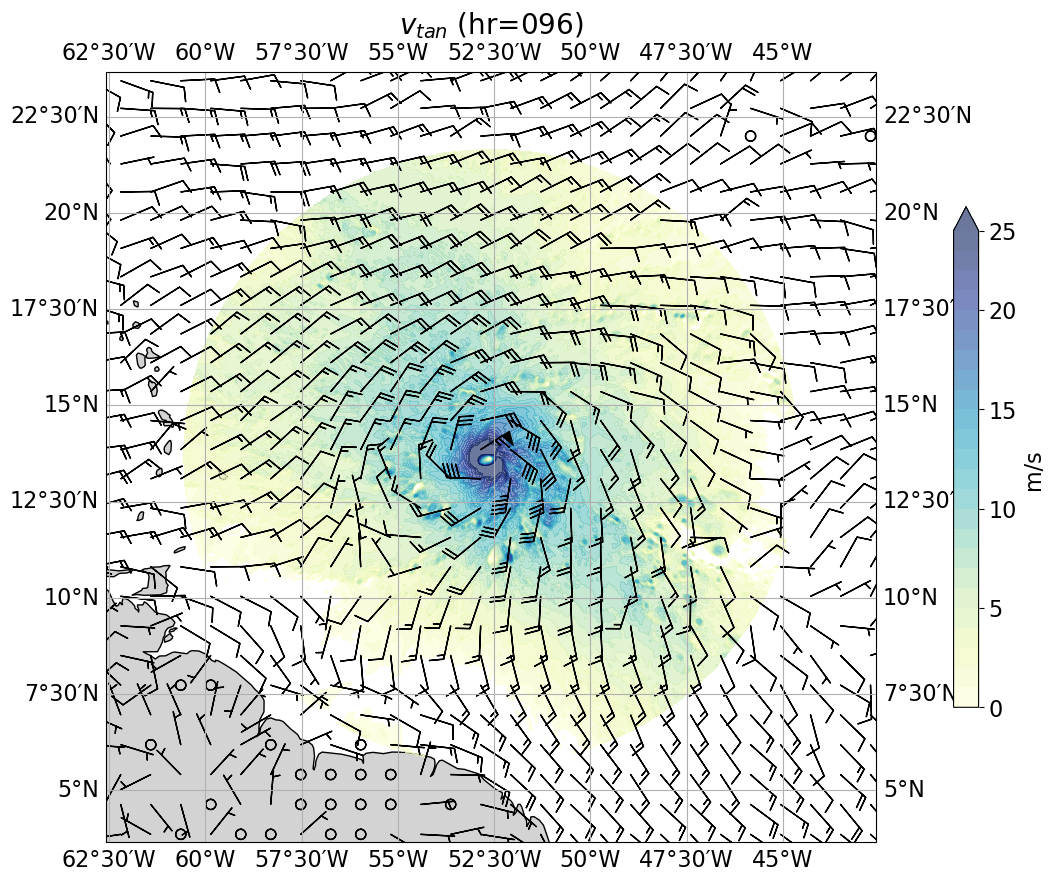

In [17]:
# Wind

# select plotting area
plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N

tsel=36
# for tsel in range(5,nt,6):
# for tsel in range(50,51):
    
hr_tag = str(np.char.zfill(str(t0), 3))

iu = u[0,0,:,:]
iv = v[0,0,:,:]
pltvar=vtan[0,0,:,:]
vartag='$v_{tan}$'
unittag='m/s'
clevs = np.arange(0,25)

# create figure
fig = plt.figure(figsize=(20,10))
proj = cartopy.crs.PlateCarree(central_longitude=offset)
ax = fig.add_subplot(111,projection=proj)
ax.set_title(vartag+' (hr='+hr_tag+')', fontsize=20)

# fill contour
im = ax.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='YlGnBu', alpha=0.6,
                    extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.65, ticks=ticker.AutoLocator())
cbar.ax.set_ylabel(unittag)

# # storm track
# plt.plot(clon, clat, color="black", linewidth=2)
# plt.plot(clon, clat, "s", color="black")
# # current time
# plt.plot(clon[t0+tsel], clat[t0+tsel], "s", color="blue", markersize=15)
# # all-time max (time step 168)
# # plt.plot(lon1d[mloc2[2]], lat1d[mloc2[1]], "s", color="blue", markersize=15)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Plot wind
skip=25
uplt = iu; vplt = iv
plot_wind(ax, uplt, vplt, lon_offset_plt, lat, skip)

# Zoom into selected area (comment this out to plot entire available area)
# ax.set_extent(plt_area)
tc_locx=clon[t0]
tc_locy=clat[t0]
rad_plt=10
plt_tcloc=[tc_locx-rad_plt, tc_locx+rad_plt, tc_locy-rad_plt, tc_locy+rad_plt] # W,E,S,N
ax.set_extent(plt_tcloc)

plt.show()
# plt.close()